In [2]:
# Libraries
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import csv

import requests
import os, json, time, random, datetime as dt

import praw
from prawcore.exceptions import RequestException, ResponseException, ServerError, Forbidden, TooManyRequests

## Sentiment Analysis

In [1]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/diegozapataalcaraz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
import re
from nltk.sentiment import SentimentIntensityAnalyzer

# === Config ===
COMMENTS_CSV = "afl_comments.csv"
TEAM = "North Melbourne"  

# Map teams to common nicknames/hashtags for matching
TEAM_ALIASES = {
    "Adelaide": ["adelaide", "crows"],
    "Brisbane": ["brisbane", "lions", "bne"],
    "Carlton": ["carlton", "blues"],
    "Collingwood": ["collingwood", "pies", "magpies"],
    "Essendon": ["essendon", "bombers", "dons"],
    "Fremantle": ["fremantle", "dockers", "freo"],
    "Geelong": ["geelong", "cats"],
    "Gold Coast": ["gold coast", "suns", "gc"],
    "GWS": ["gws", "giants", "greater western sydney"],
    "Hawthorn": ["hawthorn", "hawks"],
    "Melbourne": ["melbourne", "demons", "dees"],
    "North Melbourne": ["north melbourne", "kangaroos", "roos", "north"],
    "Port Adelaide": ["port adelaide", "power", "port"],
    "Richmond": ["richmond", "tigers", "tigs"],
    "St Kilda": ["st kilda", "saints"],
    "Sydney": ["sydney", "swans", "bloods"],
    "West Coast": ["west coast", "eagles", "wce"],
    "Western Bulldogs": ["western bulldogs", "bulldogs", "dogs", "doggies"],
}

# Build a regex to detect mentions of the target team (word boundaries; case-insensitive)
aliases = TEAM_ALIASES.get(TEAM, [TEAM])
pat = r"\b(" + "|".join(re.escape(a) for a in aliases) + r")\b"
team_re = re.compile(pat, flags=re.IGNORECASE)

# === Load comments ===
df = pd.read_csv(COMMENTS_CSV, dtype={"id": str})
df["body"] = df["body"].fillna("")

# Filter to comments that mention the team (you can skip this to score all then group)
df = df[df["body"].str.contains(team_re, na=False)]

# === VADER sentiment ===
sia = SentimentIntensityAnalyzer()

# AFL slang tweaks
sia.lexicon.update({
    "robbed": -2.0, "bottled": -1.6, "choked": -1.8, "clutch": 1.6,
    "gun": 1.2, "soft": -0.8, "dog act": -2.0, "howler": -1.5,
    "ump": -0.6, "umpiring": -0.8, "set shot": 0.3, "clanger": -1.2,
    "killer": 1.1, "cunt": -1
})

def score(txt: str) -> float:
    return sia.polarity_scores(txt)["compound"] 

df["sent"] = df["body"].astype(str).map(score)

# Simple labels
def label(x):
    if x >= 0.05: return "pos"
    if x <= -0.05: return "neg"
    return "neu"

df["label"] = df["sent"].map(label)

# Preprocessing
n = len(df)
mean_sent = df["sent"].mean() if n else 0.0
pct_pos = (df["label"].eq("pos").mean()*100) if n else 0.0
pct_neg = (df["label"].eq("neg").mean()*100) if n else 0.0

print(f"Team: {TEAM}")
print(f"Comments mentioning team: {n:,}")
print(f"Mean sentiment (compound): {mean_sent:.3f}")
print(f"% positive: {pct_pos:.1f}%   % negative: {pct_neg:.1f}%")

# Top phrases, frequent bigrams in neg/pos buckets)
from collections import Counter
def bigrams(s):
    toks = re.findall(r"[a-zA-Z']+", s.lower())
    return zip(toks, toks[1:])

top_neg = Counter(b for text in df.loc[df["label"]=="neg","body"] for b in bigrams(text)).most_common(10)
top_pos = Counter(b for text in df.loc[df["label"]=="pos","body"] for b in bigrams(text)).most_common(10)

print("\nTop negative bigrams:")
for (w1,w2), c in top_neg[:10]:
    print(f"  {w1} {w2}  ({c})")

print("\nTop positive bigrams:")
for (w1,w2), c in top_pos[:10]:
    print(f"  {w1} {w2}  ({c})")

# (Optional) Save scored comments for this team
df_out = df[["id","submission_id","created_datetime_utc","author","score","body","sent","label"]]
df_out.to_csv(f"sent_{TEAM.replace(' ','_').lower()}.csv", index=False)
print(f"\nSaved per-comment scores → sent_{TEAM.replace(' ','_').lower()}.csv")


Team: North Melbourne
Comments mentioning team: 223
Mean sentiment (compound): 0.255
% positive: 59.6%   % negative: 25.6%

Top negative bigrams:
  in the  (17)
  it was  (10)
  north melbourne  (10)
  the last  (8)
  to the  (6)
  was a  (6)
  west coast  (6)
  of their  (6)
  and north  (5)
  after the  (5)

Top positive bigrams:
  in the  (40)
  of the  (33)
  north melbourne  (28)
  as a  (23)
  to the  (19)
  on the  (18)
  in a  (17)
  would be  (15)
  the afl  (15)
  a good  (14)

Saved per-comment scores → sent_north_melbourne.csv


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_2757/209095370.py:40: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df["body"].str.contains(team_re, na=False)]


## Merge

In [6]:
afl_results_2025 = pd.read_csv("afl_results_2025.csv")
afl_results_2025 = afl_results_2025.sort_values(by="date_utc")
afl_results_2025["date_utc"] = pd.to_datetime(afl_results_2025.date_utc, utc=True)
afl_results_2025.head()

,season,round,date_utc,venue,home_team,away_team,home_goals,home_behinds,home_score,away_goals,away_behinds,away_score,winner_team,margin,is_final,is_grand_final,game_id
0,2025,0,2025-03-07 19:40:00+00:00,S.C.G.,Sydney,Hawthorn,11,10,76,14,12,96,Hawthorn,-20,0,0,37091
1,2025,0,2025-03-09 15:20:00+00:00,Sydney Showground,Greater Western Sydney,Collingwood,15,14,104,6,16,52,Greater Western Sydney,52,0,0,37093
2,2025,1,2025-03-13 19:30:00+00:00,M.C.G.,Richmond,Carlton,13,4,82,9,15,69,Richmond,13,0,0,37094
3,2025,1,2025-03-14 19:40:00+00:00,M.C.G.,Hawthorn,Essendon,17,9,111,12,13,85,Hawthorn,26,0,0,37095
4,2025,1,2025-03-15 13:20:00+00:00,Kardinia Park,Geelong,Fremantle,23,9,147,10,9,69,Geelong,78,0,0,37096


In [3]:
#Getting data
afl_comments1 = pd.read_csv("afl_comments.csv")
afl_comments2 = pd.read_csv("afl_comments2.csv")
afl_comments = pd.concat([afl_comments1, afl_comments2], axis=0, ignore_index=True)
afl_comments = afl_comments.drop_duplicates(subset=['id'], keep='first')

In [5]:
# Preprocessing
afl_comments["created_datetime_utc"] = pd.to_datetime(afl_comments.created_datetime_utc, utc=True)
afl_comments = afl_comments.sort_values(by="created_datetime_utc")
afl_comments.shape

(61596, 9)

In [7]:
afl_merge = pd.merge_asof(afl_comments, afl_results_2025, left_on="created_datetime_utc", right_on="date_utc", direction="backward")
afl_merge.head()

,id,link_id,parent_id,submission_id,author,score,created_utc,created_datetime_utc,body,season,...,home_behinds,home_score,away_goals,away_behinds,away_score,winner_team,margin,is_final,is_grand_final,game_id
0,ncoivy5,t3_1n9qaah,t3_1n9qaah,1n9qaah,Pleasant_Inspection9,7,1.757133e+09,2025-09-06 04:24:19+00:00,https://preview.redd.it/c5yqngni1hnf1.png?widt...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
1,ncokryd,t3_1n9qet4,t3_1n9qet4,1n9qet4,legally_blond,27,1.757134e+09,2025-09-06 04:38:52+00:00,>But if the broadcasters don’t want to do it t...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
2,ncokynm,t3_1n9qet4,t3_1n9qet4,1n9qet4,No-Rise2743,11,1.757134e+09,2025-09-06 04:40:21+00:00,I like the pre finals bye. Gets all the best p...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
3,ncol994,t3_1n9qet4,t3_1n9qet4,1n9qet4,lazy-bruce,0,1.757134e+09,2025-09-06 04:42:40+00:00,I like the idea of 1 bye.\n\nBut I also like t...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318
4,ncolg7q,t3_1n9qet4,t3_1n9qet4,1n9qet4,Tall-Breakfast-6100,43,1.757134e+09,2025-09-06 04:44:12+00:00,I’m all for one week bye round. Just makes so ...,2025,...,16,112,11,8,74,Geelong,38,3,0,37318


In [10]:
counts = afl_merge.groupby(afl_merge[afl_merge.created_datetime_utc <= '2025-10-01']["created_datetime_utc"].dt.date).size()
counts


created_datetime_utc
2025-09-06    10086
2025-09-07     2798
2025-09-08     1769
2025-09-09       58
2025-09-10       14
2025-09-11        6
2025-09-12     1687
2025-09-13     7248
2025-09-14     2684
2025-09-15     2599
2025-09-16     2567
2025-09-22     1706
2025-09-23     2719
2025-09-24     2903
2025-09-25     2816
2025-09-26     3158
2025-09-27     7658
2025-09-28     3275
2025-09-29     4767
2025-09-30      950
dtype: int64

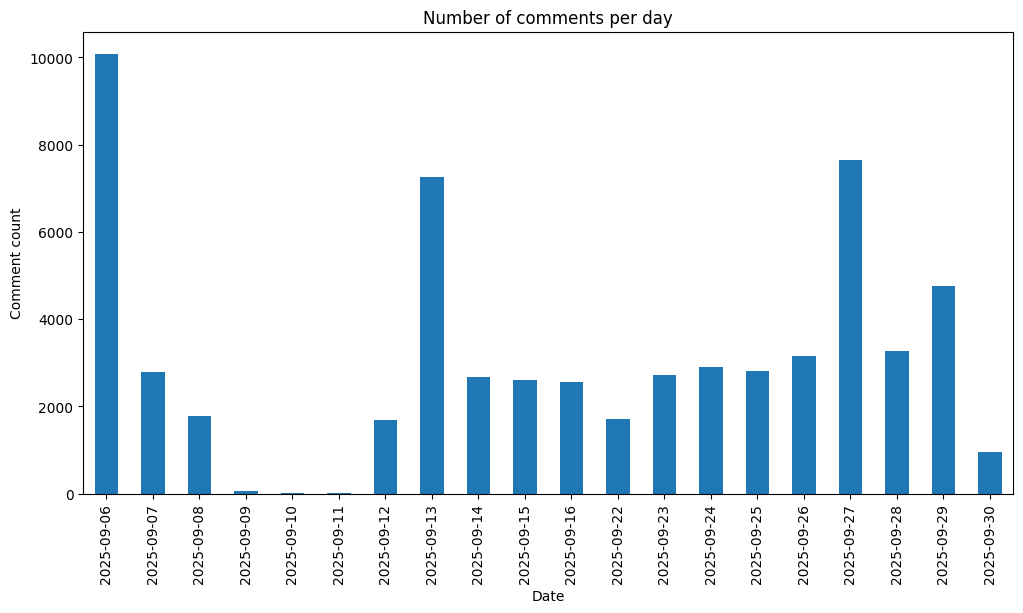

In [11]:
# Count comments per day
#counts = afl_merge.groupby(afl_merge["created_datetime_utc"].dt.date).size()
counts = afl_merge.groupby(afl_merge[afl_merge.created_datetime_utc <= '2025-10-01']["created_datetime_utc"].dt.date).size()

plt.figure(figsize=(12,6))
counts.plot(kind="bar")
plt.title("Number of comments per day")
plt.xlabel("Date")
plt.ylabel("Comment count")
plt.xticks(rotation=90)
plt.show()

In [24]:
afl_merge.columns

Index(['id', 'link_id', 'parent_id', 'submission_id', 'author', 'score',
       'created_utc', 'created_datetime_utc', 'body', 'season', 'round',
       'date_utc', 'venue', 'home_team', 'away_team', 'home_goals',
       'home_behinds', 'home_score', 'away_goals', 'away_behinds',
       'away_score', 'winner_team', 'margin', 'is_final', 'is_grand_final',
       'game_id'],
      dtype='object')